# Model Results Visualization
This notebook is intended to pull model artifacts from the Neptune experiment logger and run it on a few samples from the dataset to see visualize how the different model's are segmenting the data. 

In [10]:
from neptune import Session
import pickle
from rasterio.plot import show
import pytorch_lightning as pl
import torch
import torchvision
import zipfile
from matplotlib import pyplot
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import segmentation_models_pytorch as smp

In [11]:
image_types = ['full_channel', 'rgb', 'ir', 'hsv', 'hsv_with_ir', 'veg_index']

In [12]:
f = open("image_samples.pkl", "rb")
image_samples = pickle.load(f)

In [13]:
# create session and import my project
sesh = Session.with_default_backend(api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5"
                                "lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOGE5NDI0YTktNmE2ZC00ZWZjLTlkMjAtNjNmMTIwM2Q2ZTQzIn0=")
project = sesh.get_project("maxzvyagin/GIS")

In [14]:
experiments = project.get_experiments()

In [ ]:
experiments

In [ ]:
e = experiments[0]
e.get_system_properties()
e.get_logs()['test_loss']['y']
e.state

2class


Text(0.5, 0.98, 'Experiment: 2class, Test Loss: -0.9999933895610628')

torch.Size([1, 2, 256, 256])
tensor([[[[ -2.5993,  -5.4866,  -7.7814,  ...,  -0.3084,   0.7256,   0.2220],
          [ -4.3900,  -6.5421,  -8.5698,  ...,  -0.5590,  -0.5855,   0.2539],
          [ -7.7947,  -9.6014, -13.1293,  ...,  -0.1733,  -1.6250,  -0.8003],
          ...,
          [ -0.5403,  -1.2136,  -2.5240,  ...,  -0.8618,  -1.0064,  -0.7897],
          [  0.0792,   0.1420,  -1.1308,  ...,  -0.1406,  -0.7406,  -0.9723],
          [  0.1561,   0.0195,  -1.4304,  ...,   0.2183,  -0.0501,  -0.6385]],

         [[  5.3150,  12.5161,  11.2306,  ...,   1.6933,   0.3898,   0.4151],
          [ 10.5423,  14.2882,  15.8829,  ...,   1.6149,   0.7075,   0.4172],
          [  6.9939,  15.6503,  18.6100,  ...,   1.4470,   0.5882,  -0.4879],
          ...,
          [  1.6459,   1.1471,  -0.6387,  ...,   0.5687,   1.0754,   0.2545],
          [  0.8454,   0.7168,   0.1392,  ...,   0.7650,   0.7418,   0.5416],
          [  0.8046,   1.0558,   0.4389,  ...,   0.5478,   0.7396,  -0.2189]]]],


TypeError: transpose() received an invalid combination of arguments - got (list), but expected one of:
 * (name dim0, name dim1)
 * (int dim0, int dim1)


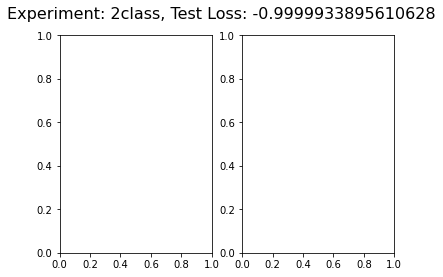

In [19]:
for e in experiments:
    id_num = int(e.get_system_properties()['id'].split('GIS-')[1])
    encoder = e.get_system_properties()['tags'][-1]
    if "encoder" in encoder:
        encoder = encoder.split("encoder")[1].lower()
    else:
        encoder = encoder.lower()
    if id_num == 299 and e.state == 'succeeded':
        # load in the model
        e.download_artifacts()
        with zipfile.ZipFile('output.zip') as zip_ref:
            zip_ref.extractall()
        f = open('output/latest_model.pkl', 'rb')
        device = torch.device('cpu')
        old_params = torch.load(f, map_location=device)
        params = dict()
        i_type = e.get_parameters()['image_type']
        if i_type == "full_channel":
            input_num = 4
        elif i_type == "rgb":
            input_num = 3
        elif i_type == "ir":
            input_num = 1
        elif i_type == "hsv":
            input_num = 3
        elif i_type == "hsv_with_ir":
            input_num = 4
        elif i_type == "veg_index":
            input_num = 1
        else:
            input_num = 4
        model = smp.Unet(classes=2, in_channels=4)
        # fix the weird state dict key error
        for k in old_params.keys():
            new_key = k.split("model.")[1]
            params[new_key] = old_params[k]
        # saving to variable to suppress huge printout
        print(encoder)
        y = model.load_state_dict(params)
        f.close()
        y = model.eval()
        # check the image type, and get image samples for corresponding image type
        # run the model on each of the samples and show results
        # print experiment id, name, image type, and training/test loss
        # print(e.get_properties(), e.get_numeric_channels_values())
        # show mask, and then show the results from each 
        for test in image_samples[i_type]:
            fig, (m_axis, i_axis) = pyplot.subplots(1, 2)
            fig.suptitle("Experiment: "+encoder+", Test Loss: "+e.get_logs()['test_loss']['y'], fontsize=16)
            if i_type == "veg_index":
                channel_input = test['image'].unsqueeze(0)
                channel_input = channel_input.unsqueeze(1)
                res = model(channel_input)
            else:
                res = model(test['image'].unsqueeze(0))
            unmodified_res = res.detach().numpy()    
#             res = torch.max(model(test['image'].unsqueeze(0)))
            #res = np.reshape(res, (2, 256, 256))
            print(res.shape) 
            print(res[:10])
            show(res, ax=i_axis, title="Model Prediction")
            show(test['mask'], ax=m_axis, title="Ground Truth")
            pyplot.show()
    

torch.Size([2, 256, 256])

torch.Size([256, 256])

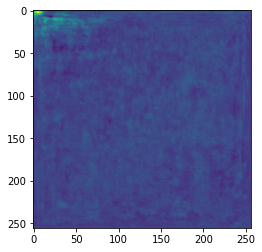

<AxesSubplot:>

In [31]:
a = res.squeeze(0)
a.shape
test = a[1]
test.shape
show(test.detach().numpy())

In [ ]:
from scipy.special import softmax
unmodified_res[:10]
calculation = softmax(unmodified_res)
calculation[:10]
show(np.rint(calculation))

In [ ]:
test['mask']

In [ ]:
for e in experiments:
    # load in the model
    e.download_artifacts()
    with zipfile.ZipFile('output.zip') as zip_ref:
        zip_ref.extractall()
    f = open('output/latest_model.pkl', 'rb')
    device = torch.device('cpu')
    old_params = torch.load(f, map_location=device)
    params = dict()
    i_type = e.get_parameters()['image_type']
    if i_type == "full_channel":
        input_num = 4
    elif i_type == "rgb":
        input_num = 3
    elif i_type == "ir":
        input_num = 1
    elif i_type == "hsv":
        input_num = 3
    elif i_type == "hsv_with_ir":
        input_num = 4
    elif i_type == "veg_index":
        input_num = 1
    else:
        i_type = 4
    model =  torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=input_num,
                                    out_channels=1,
                                    init_features=32, pretrained=False)
    # fix the weird state dict key error
    for k in old_params.keys():
        new_key = k.split("model.")[1]
        params[new_key] = old_params[k]
    model.load_state_dict(params)
    f.close()
    # check the image type, and get image samples for corresponding image type
    # run the model on each of the samples and show results
    # print experiment id, name, image type, and training/test loss
    # print(e.get_properties(), e.get_numeric_channels_values())
    # show mask, and then show the results from each 
    for test in image_samples[i_type]:
        fig, (m_axis, i_axis) = pyplot.subplots(1, 2)
        fig.suptitle("Experiment: "+e.get_system_properties()['name']+", Test Loss: "+e.get_logs()['test_loss']['y'], fontsize=16)
        if i_type == "veg_index":
            channel_input = test['image'].unsqueeze(0)
            channel_input = channel_input.unsqueeze(1)
            res = model(channel_input)
        else:
            res = model(test['image'].unsqueeze(0))
        res = np.rint(res.detach().numpy())
        show(res, ax=i_axis, title="Model Prediction")
        show(test['mask'], ax=m_axis, title="Ground Truth")
        pyplot.show()
    